In [8]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import AUC, Precision, Recall
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import glob
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from itertools import product
import seaborn as sns
from PIL import Image

In [9]:
# --- Install and import necessary libraries ---
print("--- Installing required libraries... ---")
# This ensures a clean and consistent environment for a notebook.
try:
    import splitfolders
except ImportError:
    !pip install split-folders
    import splitfolders

--- Installing required libraries... ---


In [10]:
# Define constants
DATA_DIR = 'C:\\Users\\ABHIRAM\\OneDrive\\Desktop\\alzheimers\\data'
OUTPUT_DIR = 'output'
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 64
EPOCHS = 50
SEED = 1345

In [11]:
# --- 1. Data Splitting and Loading ---
# This is a one-time operation to create a reproducible folder structure.
print("\n--- Splitting data into train, test, and validation sets... ---")
try:
    splitfolders.ratio(
        DATA_DIR,
        output=OUTPUT_DIR,
        seed=SEED,
        ratio=(0.8, 0.1, 0.1)  # 80% train, 10% val, 10% test
    )
    print("Data split successfully.")
except Exception as e:
    print(f"Data splitting failed (this is normal if it was already split): {e}")

# Load the datasets from the newly created folders.
print("\n--- Loading datasets from directories... ---")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(OUTPUT_DIR, "train"),
    seed=SEED,
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(OUTPUT_DIR, "test"),
    seed=SEED,
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(OUTPUT_DIR, "val"),
    seed=SEED,
    label_mode='categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print("Class names:", class_names)


--- Splitting data into train, test, and validation sets... ---
Data split successfully.

--- Loading datasets from directories... ---
Found 5119 files belonging to 4 classes.
Found 642 files belonging to 4 classes.
Found 639 files belonging to 4 classes.
Class names: ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


In [12]:
# --- 2. Model Building ---
print("\n--- Building the CNN model... ---")
model = keras.models.Sequential([
    keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer="he_normal"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer="he_normal"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),
    layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer="he_normal"),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation="relu", kernel_initializer="he_normal"),
    layers.Dense(32, activation="relu"),
    layers.Dense(len(class_names), activation="softmax")
])



--- Building the CNN model... ---


In [13]:
# --- 3. Model Compilation and Training ---
print("\n--- Compiling and training the model... ---")
model.compile(
    loss="categorical_crossentropy",
    optimizer="Adam",
    metrics=[
        'accuracy',
        AUC(name='auc'),
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, dpi=150)

earlystopping = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=10,
    verbose=1
)

checkpoint_filepath = './cnn_best_weights.weights.h5'
checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

callbacks_list = [earlystopping, checkpoint]
hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks_list
)



--- Compiling and training the model... ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,125,124 (8.11 MB)

 Trainable params: 2,125,124 (8.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.4414 - auc: 0.6980 - loss: 2.7269 - precision: 0.4238 - recall: 0.2735
Epoch 1: val_accuracy improved from None to 0.50078, saving model to ./cnn_best_weights.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 26s 289ms/step - accuracy: 0.4788 - auc: 0.7498 - loss: 1.5651 - precision: 0.4873 - recall: 0.2885 - val_accuracy: 0.5008 - val_auc: 0.8002 - val_loss: 1.1054 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.5126 - auc: 0.8043 - loss: 1.0091 - precision: 0.5663 - recall: 0.4281
Epoch 2: val_accuracy improved from 0.50078 to 0.52426, saving model to ./cnn_best_weights.weights.h5
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - accuracy: 0.5009 - auc: 0.8002 - loss: 1.0060 - precision: 0.5752 - recall: 0.3536 - val_accuracy: 0.5243 - val_auc: 0.7958 - val_loss: 1.0902 - val_precision: 1.0000 - val_recall: 0.0063
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step -


--- Evaluating the model on the test dataset... ---
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9891 - auc: 0.9998 - loss: 0.0375 - precision: 0.9891 - recall: 0.9891

Test Loss = 0.0375
Test Accuracy = 0.9891
Test AUC = 0.9998
Test Precision = 0.9891
Test Recall = 0.9891
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step

--- Confusion Matrix ---


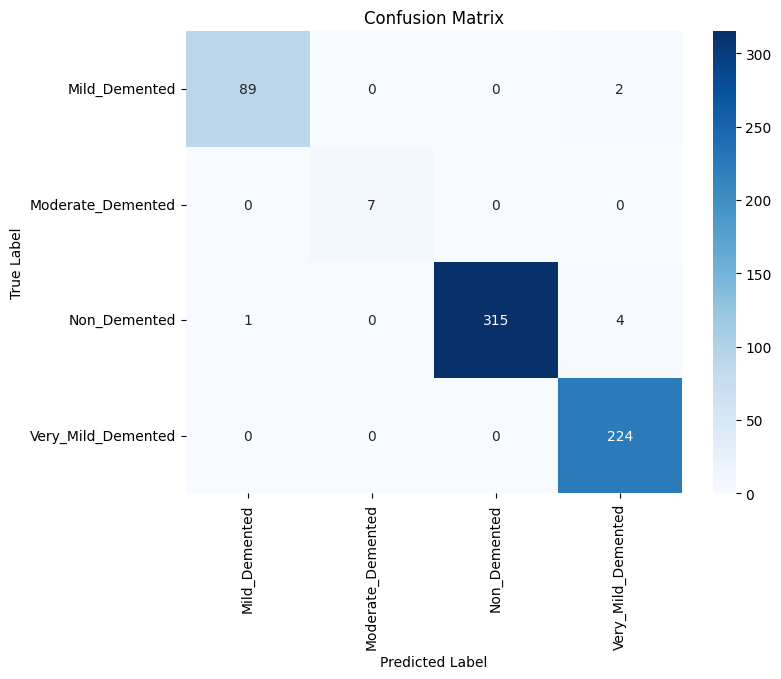


--- Classification Report ---
                    precision    recall  f1-score   support

     Mild_Demented       0.99      0.98      0.98        91
 Moderate_Demented       1.00      1.00      1.00         7
      Non_Demented       1.00      0.98      0.99       320
Very_Mild_Demented       0.97      1.00      0.99       224

          accuracy                           0.99       642
         macro avg       0.99      0.99      0.99       642
      weighted avg       0.99      0.99      0.99       642



In [ ]:
# --- 4. Evaluation and Visualization ---
print("\n--- Evaluating the model on the test dataset... ---")
results = model.evaluate(test_ds)
test_loss = results[0]
test_accuracy = results[1]
test_auc = results[2]
test_precision = results[3]
test_recall = results[4]

print(f'\nTest Loss = {test_loss:.4f}')
print(f'Test Accuracy = {test_accuracy:.4f}')
print(f'Test AUC = {test_auc:.4f}')
print(f'Test Precision = {test_precision:.4f}')
print(f'Test Recall = {test_recall:.4f}')

# Get true and predicted labels for confusion matrix and classification report
y_true_list = []
y_pred_list = []
for images, labels in test_ds:
    preds = model.predict(images)
    y_true_list.extend(np.argmax(labels.numpy(), axis=1))
    y_pred_list.extend(np.argmax(preds, axis=1))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true_list, y_pred_list)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()  

print("\n--- Classification Report ---")
print(classification_report(y_true_list, y_pred_list, target_names=class_names))



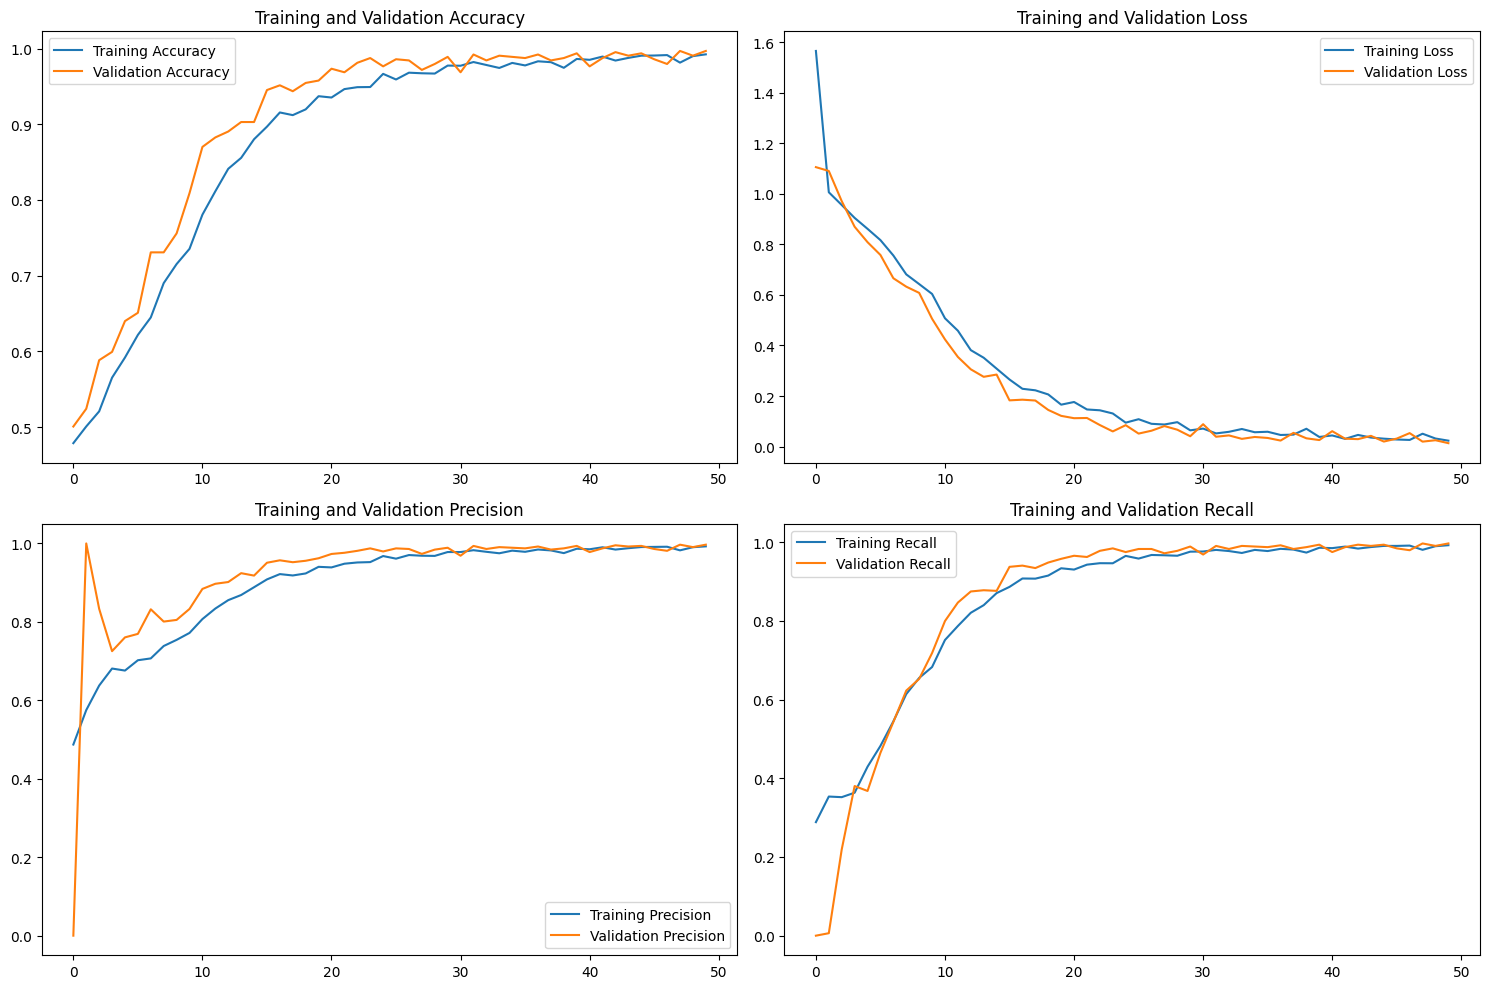

In [15]:
# Plotting
history_df = pd.DataFrame(hist.history)
plt.figure(figsize=(15, 10))

# Plot Accuracy, Loss
plt.subplot(2, 2, 1)
plt.plot(history_df['accuracy'], label='Training Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history_df['loss'], label='Training Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Precision, Recall, AUC
plt.subplot(2, 2, 3)
plt.plot(history_df['precision'], label='Training Precision')
plt.plot(history_df['val_precision'], label='Validation Precision')
plt.title('Training and Validation Precision')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(history_df['recall'], label='Training Recall')
plt.plot(history_df['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# --- 5. Single-Image Classification ---
print("\n--- Testing single-image classification... ---")

def classify_single_image(image_path, confidence_threshold=0.85):
    """
    Loads, preprocesses, and classifies a single image with confidence check.
    
    Args:
        image_path (str): The file path to the JPG image.
    """
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return

    print(f"--- Classifying image: {image_path} ---")
    img = Image.open(image_path).convert('RGB')
    img = img.resize((IMG_HEIGHT, IMG_WIDTH))
    img_array = np.array(img).astype('float32') / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    predictions = model.predict(img_array)[0]
    
    predicted_class_index = np.argmax(predictions)
    confidence_score = predictions[predicted_class_index]

    print("\nPrediction complete.")
    print("--- Detailed Probabilities ---")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {predictions[i]*100:.2f}%")

    # Apply the confidence threshold
    print("\n--- Final Diagnosis ---")
    if confidence_score >= confidence_threshold:
        print(f"The model confidently predicts this scan comes under the category: {class_names[predicted_class_index]}.")
        print(f"Confidence score: {confidence_score*100:.2f}%")
        return class_names[predicted_class_index]
    else:
        print("The model's prediction confidence is below the threshold.")
        print("This scan requires further clinical analysis for diagnosis.")
        return "Requires Further Clinical Analysis"



--- Testing single-image classification... ---


In [17]:
# --- Example Usage ---
# NOTE: This creates a dummy image. Replace the path with your own JPG.
dummy_image_path = 'C:\\Users\\ABHIRAM\\OneDrive\\Desktop\\alzheimers\\notebooks\\MRI_of_Human_Brain.jpg'
dummy_image = np.random.randint(0, 256, size=(IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
plt.imsave(dummy_image_path, dummy_image)
print("\n--- Running single-image classification on a sample image... ---")
classify_single_image(dummy_image_path)


--- Running single-image classification on a sample image... ---
--- Classifying image: C:\Users\ABHIRAM\OneDrive\Desktop\alzheimers\notebooks\MRI_of_Human_Brain.jpg ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Prediction complete.
--- Detailed Probabilities ---
Mild_Demented: 22.16%
Moderate_Demented: 22.58%
Non_Demented: 25.82%
Very_Mild_Demented: 29.45%

--- Final Diagnosis ---
The model's prediction confidence is below the threshold.
This scan requires further clinical analysis for diagnosis.


'Requires Further Clinical Analysis'